<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Adapters in PyTorch**

Estimated time needed: **45** minutes

**_Note to advanced users_: If you are already familiar with classical fine-tuning and you only want to see the section that relates to adapters, skip forward to <a href="#Adapters">Adapters</a> and run all of the cells above that section by going to _Run --> Run All Above Selected Cell_**

You can fine-tune a neural network in several ways. Common strategies include adjusting only the final layer or fine-tuning all layers. However, these methods have their drawbacks: fine-tuning just the final layer often leads to less than optimal results, while fine-tuning all layers can be very time-consuming.

To address these issues, researchers have developed various parameter efficient fine-tuning (PEFT) techniques. One such technique involves the use of adapters. Adapters enable modular training, where small, task-specific modules are trained within the model without changing the pre-existing pretrained parameters. This approach efficiently tailors the model to new tasks with a reduced risk of overfitting. However, adapters are not a cure-all solution. While they are less likely to overfit and are computationally efficient, they might not always reach the same level of accuracy as full model fine-tuning, particularly if the task necessitates substantial changes from the pretrained model's original capabilities.

In this hands-on lab, you learn how to apply an adapter to a transformer-based neural network that has been trained on the AG News data set, with the aim of using this model on the IMDB data set. You also evaluate and compare the performance of this method with that of a fully fine-tuned model and a model where only the last layer is fine-tuned.



# __Table of contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Install-required-libraries">Install required libraries</a></li>
            <li><a href="#Import-required-libraries">Import required libraries</a></li>
            <li><a href="#Define-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li><a href="#Positional-encodings">Positional encodings</a></li>
    <li><a href="#Import-IMDB-dataset">Import IMDB data set</a></li>
    <ol>
        <li><a href="#IMDB-dataset-overview">IMDB data set overview</a></li>
        <ol>
            <li><a href="#Dataset-composition">Data set composition</a></li>
            <li><a href="#Applications">Applications</a></li>
            <li><a href="#Challenges">Challenges</a></li>
            <li><a href="#Dataset-splits">Data set splits</a></li>
            <li><a href="#Data-loader">Data loader</a></li>
            <li><a href="#Neural-network">Neural network</a></li>
        </ol>
    </ol>
    <li>
        <a href="#Training">Training</a>
        <ol>
            <li><a href="#Train-IMDB">Train IMDB</a></li>
            <li><a href="#Fine-tune-a-model-pretrained-on-the-AG-News-dataset">Fine-tune a model pretrained on the AG News data set</a></li>
            <li><a href="#Fine-tune-the-final-layer-only">Fine-tune the final layer only</a></li>
        </ol>
    </li>
    <li>
        <a href="#Adapters">Adapters</a>
        <ol>
            <li><a href="#Benefits-of-using-adapters-in-neural-networks">Benefits of using adapters in neural networks</a></li>
        </ol>
    </li>
    <li>
        <a href="#Exercise:-Adapt-linear-layers-in-a-different-network">Exercise: Adapt linear layers in a different network</a>
    </li>
</ol>


---


# Objectives

After completing this lab, you are able to:

- Define and pretrain a transformer-based neural network using PyTorch for a classification task [Optional]
- Fully fine-tune the pretrained model for a different classification task [Optional]
- Compare results by fine-tuning only the last layer of the pretrained model [Optional]
- Understand how adapters work
- Apply adapters to linear layers in a neural network
- Train a neural network in a parameter efficient way by training just the adapted layers



---


# Setup


### Install required libraries


For this lab, you use the following libraries, which are __not__ preinstalled in the Skills Network Labs environment. __You must run the code in the following cell__ to install them.


In [ ]:
!pip install torch==2.2.2
!pip install torchtext==0.17.2
!pip install portalocker==2.8.2
!pip install torchdata==0.7.1
!pip install plotly==5.22.0
!pip install pandas
!pip install matplotlib==3.9.0 scikit-learn==1.5.0

In [ ]:
!pip install numpy==1.26.0

### Import required libraries

The following code imports the required libraries.


In [1]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
torch.set_num_threads(1)
from torch import nn
import os


from torch.utils.data import DataLoader

from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, Vectors
from torchtext.datasets import IMDB
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pickle

from urllib.request import urlopen
import io

import tarfile
import tempfile

from torch.nn.utils.rnn import pad_sequence

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Define helper functions

The following code shows some helper functions to help with plotting, saving, and loading files. These functions are not the main focus of this lab, so you do not have to dwell on these too long. However, do run the cells in this section to define these helper functions.


In [2]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [3]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

---


# Positional encodings

Positional encodings play a pivotal role in transformers and various sequence-to-sequence models, aiding in conveying critical information regarding the positions or sequencing of elements within a given sequence. To illustrate, let's examine the sentences: "He painted the car red" and "He painted the red car." Despite their distinct meanings, it's worth noting that the embeddings for these sentences remain identical in the absence of positional encodings. The following class defines positional encodings by inheriting from PyTorch's `Module` class.


In [4]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

# Import IMDB data set


The following code loads the IMDB data set.


In [5]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

## IMDB data set overview

The **IMDB data set** contains movie reviews from the Internet Movie Database (IMDB) and is commonly used for binary sentiment classification tasks. It's a popular data set for training and testing models in natural language processing (NLP), particularly in the context of sentiment analysis.

### Data set composition

- **Reviews**: The data set consists of 50,000 movie reviews, divided evenly into 25,000 training and 25,000 testing samples.
- **Sentiment labels**: Each review is labeled as either positive or negative, indicating the sentiment expressed in the review. The data set is balanced, with an equal number of positive and negative reviews in both the training and testing sets.
- **Text content**: Reviews are presented as plain text and have been preprocessed to some extent. For example, HTML tags are removed, but the text retains its original punctuation and capitalization.
- **Usage**: The data set is commonly used to train models for binary sentiment classification, where the goal is to predict whether a given review is positive or negative based on its text content.

### Applications

- **Sentiment analysis**: The primary application of the IMDB data set is in sentiment analysis, where it serves as a benchmark for various text classification algorithms.
- **Natural language processing**: The data set is widely used in NLP research and applications, providing a basis for testing the effectiveness of different models and approaches in understanding human language.

### Challenges

The data set is small, so it's hard to train a model from scratch.

The following class is defined to traverse the IMDB data set. The need to define this class arises from the fact that the IMDB data set is split across a large number of files.


In [6]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

The following code uses the `IMDBDataset` class previously defined to create iterators for the train and test data sets. In the latter part of the cell, you can return 20 examples from the train set.


In [7]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test data

start=train_iter.pos_inx
for i in range(-10,10):
    print(train_iter[start+i])

(0, "On his birthday a small boys tells his mother he is not her son, and that he wants to go home to his real mother.<br /><br />In some ways Comedy De L'Innocence feels like it comes from a different time of movie-making, perhaps the 60's or 70's. Certainly it reminded me of Losey's Secret Ceremony (1968), and Richard Loncraine's Full Circle (1977), both of which deal with loss, grief and relationships between parents and 'lost' children (curiously both films star Mia Farrow).<br /><br />All three films are populated with unsympathetic characters who behave in strange and unexplained ways. All three films have a chilly feel, both emotionally and literally. All three films focus on mother-child relationships, and ultimately all three films pose the question - 'what is real, what is imagined?' <br /><br />Beautiful but flawed, it offers no easy answers and leaves much hanging, unexplained and strange.")
(0, "Seriously, what is THIS? Hooper has made such classic films like Texas Chainsa

The following code defines the mapping of numeric labels to positive and negative reviews.


In [8]:
imdb_label = {0: " negative review", 1: "positive review"}
imdb_label[1]

'positive review'

The following code checks to ensure that there are exactly two classes in the train data set.


In [9]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

The following code loads a basic English tokenizer and defines a function called ```yield_tokens``` that uses the tokenizer to break down text data yielded by an iterator into tokens.


In [10]:
tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    """Yield tokens for each data sample."""
    for _, text in data_iter:
        yield tokenizer(text)

 The following code loads a pretrained word embedding model called GloVe into a variable called `glove_embedding`.


In [11]:
# Note that GloVe embeddings are typically downloaded using:
#glove_embedding = GloVe(name="6B", dim=100)
# However, the GloVe server is frequently down. The code below offers a workaround


class GloVe_override(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        #name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override, self).__init__(name, url=url, **kwargs)

class GloVe_override2(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        #name = "glove.{}.{}d.txt".format(name, str(dim))
        name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override2, self).__init__(name, url=url, **kwargs)

try:
    glove_embedding = GloVe_override(name="6B", dim=100)
except:
    try:
        glove_embedding = GloVe_override2(name="6B", dim=100)
    except:
        glove_embedding = GloVe(name="6B", dim=100)

.vector_cache/glove-6B.zip: 134MB [00:29, 4.61MB/s]                              
100%|█████████▉| 399999/400000 [00:33<00:00, 11802.44it/s]


The following code builds a vocabulary object from a pretrained GloVe word embedding model and sets the default index to the <unk> token.


In [12]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

Let's count the number of words in the vocab:


In [13]:
vocab_size=len(vocab)
vocab_size

400002

Let's test the ```vocab``` function:


In [14]:
vocab(['he'])

[20]

### Data set splits


The following converts the data set into map-style data sets and then performs a random split to create separate training and validation data sets. The training data set will contain 95% of the samples in the original training set, while the validation data set will contain the remaining 5%. These data sets can be used for training and evaluating a machine learning model for text classification on the IMDB data set. The final performance of the model will be evaluated on the hold-out test set.


In [15]:
# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

Be aware that the Skills Network currently does not offer GPU access to learners. As a result, training on the full data set could be time-consuming. To address this, you further reduce the size of the training set. This approach helps you mimic the training process as if a GPU were available. However, if you want to train using the full IMDB data set, you must either comment out or remove the two lines in the following code block.


In [16]:
num_train = int(len(train_dataset) * 0.05)
split_train_, _ = random_split(split_train_, [num_train, len(split_train_) - num_train])

The following code checks to see if a CUDA-compatible GPU is available in the system using PyTorch, a popular deep learning framework. If a GPU is available, it assigns the device variable to "cuda" (which stands for CUDA, the parallel computing platform and application programming interface model developed by NVIDIA). If a GPU is not available, it assigns the device variable to "cpu" (which means the code will run on the CPU instead).


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data loader


The following code prepares the text processing pipeline with the tokenizer and vocabulary. The text pipeline is used to process the raw data strings from the data set iterators.

The function **```text_pipeline```** first tokenizes the input text, then **```vocab```** is applied to get the token indices.


In [18]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples. The provided code defines a `collate_batch` function in PyTorch, which is used with data loaders to customize batch creation from individual samples. It processes a batch of data, including labels and text sequences. It applies the `text_pipeline` function to preprocess the text. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (for example, GPU) for efficient computation.


In [19]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

You can convert the data set objects to data loaders by applying the `collate` function.


In [20]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

Let's check to see what these data loaders generate.


In [21]:
label,seqence=next(iter(valid_dataloader))
label,seqence

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0'),
 tensor([[   39,    16,    50,  ...,     0,     0,     0],
         [   12,  8885,     7,  ...,     0,     0,     0],
         [   43,    35,    86,  ...,     0,     0,     0],
         ...,
         [   43,    35,   334,  ...,     0,     0,     0],
         [    2,    71,    40,  ...,     0,     0,     0],
         [10486, 10782,    25,  ...,     0,     0,     0]], device='cuda:0'))

### Neural network


This code defines a class called Net that represents a text classifier based on a PyTorch TransformerEncoder.
The constructor takes the following arguments:

- `num_class`: The number of classes to classify
- `vocab_size`: The size of the vocabulary
- `freeze`: Whether to freeze the embedding layer
- `nhead`: The number of heads in the transformer encoder
- `dim_feedforward`: The dimension of the feedforward layer in the transformer encoder
- `num_layers`: The number of transformer encoder layers
- `dropout`: The dropout rate
- `activation`: The activation function to use in the transformer encoder
- `classifier_dropout`: The dropout rate for the classifier

**Attributes:**

- `emb`: An embedding layer that maps each word in the vocabulary to a dense vector representation
- `pos_encoder`: A positional encoding layer that adds positional information to the word vectors
- `transformer_encoder`: A transformer encoder layer that processes the sequence of word vectors and extracts high-level features
- `classifier`: A linear layer that maps the output of the transformer encoder to the desired number of classes

---




In [22]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        #self.emb = embedding=nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        self.emb = nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

The model can then be trained on labeled data from the IMDB data set with two classes.


Let's create the model.


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_class=2,vocab_size=vocab_size).to(device)
model

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

The following **`predict`** function takes in a text, a text pipeline, and a model as inputs. It uses a pretrained model passed as a parameter to predict the label of the text for text classification on the IMDB data set.


In [24]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [25]:
predict("I like sports and stuff", text_pipeline, model)

' negative review'

You can create a function to evaluate the model's accuracy on a data set. Here, you define two nearly identical evaluation functions, one that provides a `tqdm` progress bar, and one that does not.


In [26]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in tqdm(dataloader):
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [27]:
def evaluate_no_tqdm(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

The following code evaluates the performance of your model. Note that this can take approximately 4 minutes on a CPU. **For efficiency, let's not run this cell now, but trust us that the performance of the untrained model is no better than average. If you wish to confirm yourself of this fact, you are free to uncomment this cell**:


In [28]:
evaluate(test_dataloader, model)

100%|██████████| 782/782 [00:09<00:00, 86.58it/s]


0.50028

Note that the current performance of the model is no better than average. This outcome is expected, considering that the model has not undergone any training yet.


---


# Training


The following coe defines the training function used to train your model.


In [33]:
def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        #print(model)
        #for parm in model.parameters():
        #    print(parm.requires_grad)
        
        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            #print(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate_no_tqdm(valid_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                pass
                #print("save model epoch",epoch)
                #torch.save(model.state_dict(), model_path)
                #save_list_to_file(lst=acc_epoch, filename=acc_dir)
                #save_list_to_file(lst=cum_loss_list, filename=loss_dir)

    time_end = time.time()
    print(f"Training time: {time_end - time_start}")
    return cum_loss_list, acc_epoch

### Train IMDB

The following code sets the learning rate (LR) to 1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multiclass classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.

For the sake of time efficiency, **the following lines are commented out and the model is not actually trained**. If you would like to get a glimpse of what training would look like, uncomment the following code block to train the model for 2 epochs. If you were to train this model in a real-world scenario, you would likely increase the number of epochs to a larger figure, such as 100 or more. Given the reduced training set defined earlier, it takes approximately 2 minutes to complete 2 epochs of training.


In [36]:
''''''
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_IMDB dataset small2.pth"
loss, acc = train_model(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            train_dataloader=train_dataloader, 
            valid_dataloader=valid_dataloader, 
            epochs=100, 
            save_dir=save_dir, 
            file_name=file_name
           )


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Loss: 21.242357462644577


  1%|          | 1/100 [00:01<02:33,  1.55s/it]

0.6856
Epoch 2/100 - Loss: 20.440556406974792


  2%|▏         | 2/100 [00:03<02:29,  1.52s/it]

Epoch 3/100 - Loss: 20.706941694021225


  3%|▎         | 3/100 [00:04<02:26,  1.51s/it]

Epoch 4/100 - Loss: 20.549553394317627


  4%|▍         | 4/100 [00:06<02:24,  1.51s/it]

Epoch 5/100 - Loss: 19.3784698843956


  5%|▌         | 5/100 [00:07<02:23,  1.51s/it]

Epoch 6/100 - Loss: 19.71237424015999


  6%|▌         | 6/100 [00:09<02:23,  1.52s/it]

Epoch 7/100 - Loss: 21.295063078403473


  7%|▋         | 7/100 [00:10<02:22,  1.53s/it]

Epoch 8/100 - Loss: 19.747621446847916


  8%|▊         | 8/100 [00:12<02:19,  1.51s/it]

0.7152
Epoch 9/100 - Loss: 19.776281032711267


  9%|▉         | 9/100 [00:13<02:17,  1.51s/it]

0.724
Epoch 10/100 - Loss: 20.368078529834747


 10%|█         | 10/100 [00:15<02:15,  1.51s/it]

Epoch 11/100 - Loss: 18.92344679310918


 11%|█         | 11/100 [00:16<02:13,  1.50s/it]

Epoch 12/100 - Loss: 21.48756641149521


 12%|█▏        | 12/100 [00:18<02:12,  1.51s/it]

Epoch 13/100 - Loss: 19.18272577226162


 13%|█▎        | 13/100 [00:19<02:12,  1.52s/it]

Epoch 14/100 - Loss: 18.99321448802948


 14%|█▍        | 14/100 [00:21<02:10,  1.51s/it]

Epoch 15/100 - Loss: 20.052155941724777


 15%|█▌        | 15/100 [00:22<02:08,  1.51s/it]

0.728
Epoch 16/100 - Loss: 19.676414489746094


 16%|█▌        | 16/100 [00:24<02:06,  1.50s/it]

Epoch 17/100 - Loss: 20.58471715450287


 17%|█▋        | 17/100 [00:25<02:06,  1.52s/it]

Epoch 18/100 - Loss: 20.80602875351906


 18%|█▊        | 18/100 [00:27<02:04,  1.52s/it]

Epoch 19/100 - Loss: 19.42275360226631


 19%|█▉        | 19/100 [00:28<02:02,  1.51s/it]

Epoch 20/100 - Loss: 21.27736520767212


 20%|██        | 20/100 [00:30<02:00,  1.51s/it]

Epoch 21/100 - Loss: 19.142515420913696


 21%|██        | 21/100 [00:31<01:59,  1.51s/it]

Epoch 22/100 - Loss: 20.915090173482895


 22%|██▏       | 22/100 [00:33<01:57,  1.51s/it]

Epoch 23/100 - Loss: 20.157212376594543


 23%|██▎       | 23/100 [00:34<01:55,  1.51s/it]

0.7288
Epoch 24/100 - Loss: 19.544904947280884


 24%|██▍       | 24/100 [00:36<01:55,  1.52s/it]

Epoch 25/100 - Loss: 19.850621283054352


 25%|██▌       | 25/100 [00:37<01:54,  1.52s/it]

Epoch 26/100 - Loss: 18.28654193878174


 26%|██▌       | 26/100 [00:39<01:52,  1.52s/it]

Epoch 27/100 - Loss: 19.52664053440094


 27%|██▋       | 27/100 [00:40<01:50,  1.51s/it]

Epoch 28/100 - Loss: 20.185354083776474


 28%|██▊       | 28/100 [00:42<01:48,  1.51s/it]

Epoch 29/100 - Loss: 17.77624474442564


 29%|██▉       | 29/100 [00:43<01:47,  1.51s/it]

Epoch 30/100 - Loss: 18.929060369729996


 30%|███       | 30/100 [00:45<01:46,  1.52s/it]

Epoch 31/100 - Loss: 17.152635887265205


 31%|███       | 31/100 [00:46<01:44,  1.52s/it]

Epoch 32/100 - Loss: 19.48749366402626


 32%|███▏      | 32/100 [00:48<01:43,  1.52s/it]

Epoch 33/100 - Loss: 18.825171172618866


 33%|███▎      | 33/100 [00:49<01:41,  1.51s/it]

Epoch 34/100 - Loss: 18.85375088453293


 34%|███▍      | 34/100 [00:51<01:40,  1.52s/it]

Epoch 35/100 - Loss: 17.056719326079474


 35%|███▌      | 35/100 [00:53<01:38,  1.52s/it]

Epoch 36/100 - Loss: 17.44758492708206


 36%|███▌      | 36/100 [00:54<01:37,  1.52s/it]

Epoch 37/100 - Loss: 17.111870795488358


 37%|███▋      | 37/100 [00:56<01:35,  1.51s/it]

Epoch 38/100 - Loss: 16.91005054861307


 38%|███▊      | 38/100 [00:57<01:34,  1.53s/it]

Epoch 39/100 - Loss: 16.78866619616747


 39%|███▉      | 39/100 [00:59<01:33,  1.53s/it]

Epoch 40/100 - Loss: 18.17802259325981


 40%|████      | 40/100 [01:00<01:31,  1.52s/it]

Epoch 41/100 - Loss: 20.119217604398727


 41%|████      | 41/100 [01:02<01:28,  1.51s/it]

0.7512
Epoch 42/100 - Loss: 17.335750445723534


 42%|████▏     | 42/100 [01:03<01:27,  1.51s/it]

Epoch 43/100 - Loss: 20.579044997692108


 43%|████▎     | 43/100 [01:05<01:26,  1.52s/it]

Epoch 44/100 - Loss: 19.670663446187973


 44%|████▍     | 44/100 [01:06<01:25,  1.52s/it]

Epoch 45/100 - Loss: 18.646895185112953


 45%|████▌     | 45/100 [01:08<01:23,  1.52s/it]

Epoch 46/100 - Loss: 16.45590528799221


 46%|████▌     | 46/100 [01:09<01:21,  1.52s/it]

Epoch 47/100 - Loss: 19.617421492934227


 47%|████▋     | 47/100 [01:11<01:20,  1.51s/it]

Epoch 48/100 - Loss: 19.111478880047798


 48%|████▊     | 48/100 [01:12<01:19,  1.52s/it]

Epoch 49/100 - Loss: 16.76862695813179


 49%|████▉     | 49/100 [01:14<01:17,  1.53s/it]

Epoch 50/100 - Loss: 16.556046898011118


 50%|█████     | 50/100 [01:15<01:17,  1.55s/it]

Epoch 51/100 - Loss: 16.39573773741722


 51%|█████     | 51/100 [01:17<01:15,  1.55s/it]

Epoch 52/100 - Loss: 16.279582157731056


 52%|█████▏    | 52/100 [01:18<01:14,  1.54s/it]

Epoch 53/100 - Loss: 17.69402515888214


 53%|█████▎    | 53/100 [01:20<01:11,  1.53s/it]

Epoch 54/100 - Loss: 15.314097061753273


 54%|█████▍    | 54/100 [01:21<01:09,  1.52s/it]

Epoch 55/100 - Loss: 16.83300791680813


 55%|█████▌    | 55/100 [01:23<01:08,  1.53s/it]

Epoch 56/100 - Loss: 14.944964557886124


 56%|█████▌    | 56/100 [01:25<01:07,  1.54s/it]

Epoch 57/100 - Loss: 15.844130530953407


 57%|█████▋    | 57/100 [01:26<01:05,  1.53s/it]

Epoch 58/100 - Loss: 15.653686940670013


 58%|█████▊    | 58/100 [01:28<01:04,  1.53s/it]

Epoch 59/100 - Loss: 16.17133468389511


 59%|█████▉    | 59/100 [01:29<01:03,  1.54s/it]

Epoch 60/100 - Loss: 16.706897735595703


 60%|██████    | 60/100 [01:31<01:01,  1.54s/it]

Epoch 61/100 - Loss: 20.19864632189274


 61%|██████    | 61/100 [01:32<00:59,  1.54s/it]

Epoch 62/100 - Loss: 18.944785743951797


 62%|██████▏   | 62/100 [01:34<00:58,  1.53s/it]

Epoch 63/100 - Loss: 18.78449085354805


 63%|██████▎   | 63/100 [01:35<00:56,  1.52s/it]

Epoch 64/100 - Loss: 21.275704011321068


 64%|██████▍   | 64/100 [01:37<00:54,  1.52s/it]

Epoch 65/100 - Loss: 15.517385348677635


 65%|██████▌   | 65/100 [01:38<00:52,  1.51s/it]

Epoch 66/100 - Loss: 16.715482980012894


 66%|██████▌   | 66/100 [01:40<00:51,  1.51s/it]

Epoch 67/100 - Loss: 17.530437365174294


 67%|██████▋   | 67/100 [01:41<00:50,  1.52s/it]

Epoch 68/100 - Loss: 20.56000444293022


 68%|██████▊   | 68/100 [01:43<00:50,  1.57s/it]

Epoch 69/100 - Loss: 21.448566555976868


 69%|██████▉   | 69/100 [01:45<00:49,  1.60s/it]

Epoch 70/100 - Loss: 14.056194871664047


 70%|███████   | 70/100 [01:46<00:47,  1.59s/it]

0.7536
Epoch 71/100 - Loss: 17.948025569319725


 71%|███████   | 71/100 [01:48<00:45,  1.57s/it]

Epoch 72/100 - Loss: 14.258403016574448


 72%|███████▏  | 72/100 [01:49<00:44,  1.58s/it]

Epoch 73/100 - Loss: 17.50269842147827


 73%|███████▎  | 73/100 [01:51<00:42,  1.57s/it]

Epoch 74/100 - Loss: 15.152475595474243


 74%|███████▍  | 74/100 [01:52<00:40,  1.55s/it]

Epoch 75/100 - Loss: 17.82137133181095


 75%|███████▌  | 75/100 [01:54<00:38,  1.54s/it]

Epoch 76/100 - Loss: 16.83822211623192


 76%|███████▌  | 76/100 [01:55<00:36,  1.54s/it]

Epoch 77/100 - Loss: 14.580362379550934


 77%|███████▋  | 77/100 [01:57<00:35,  1.53s/it]

Epoch 78/100 - Loss: 13.721417114138603


 78%|███████▊  | 78/100 [01:59<00:33,  1.54s/it]

Epoch 79/100 - Loss: 15.001624688506126


 79%|███████▉  | 79/100 [02:00<00:32,  1.53s/it]

Epoch 80/100 - Loss: 18.804302603006363


 80%|████████  | 80/100 [02:02<00:30,  1.54s/it]

Epoch 81/100 - Loss: 14.3705445677042


 81%|████████  | 81/100 [02:03<00:29,  1.53s/it]

Epoch 82/100 - Loss: 18.49994534254074


 82%|████████▏ | 82/100 [02:05<00:27,  1.52s/it]

Epoch 83/100 - Loss: 15.752544969320297


 83%|████████▎ | 83/100 [02:06<00:26,  1.53s/it]

Epoch 84/100 - Loss: 13.388606619089842


 84%|████████▍ | 84/100 [02:08<00:24,  1.53s/it]

Epoch 85/100 - Loss: 14.347699359059334


 85%|████████▌ | 85/100 [02:09<00:22,  1.52s/it]

Epoch 86/100 - Loss: 13.979253351688385


 86%|████████▌ | 86/100 [02:11<00:21,  1.53s/it]

Epoch 87/100 - Loss: 17.69158338010311


 87%|████████▋ | 87/100 [02:12<00:20,  1.54s/it]

Epoch 88/100 - Loss: 16.245656743645668


 88%|████████▊ | 88/100 [02:14<00:18,  1.54s/it]

Epoch 89/100 - Loss: 14.069378733634949


 89%|████████▉ | 89/100 [02:15<00:17,  1.55s/it]

Epoch 90/100 - Loss: 15.271211758255959


 90%|█████████ | 90/100 [02:17<00:15,  1.56s/it]

Epoch 91/100 - Loss: 14.06145665049553


 91%|█████████ | 91/100 [02:19<00:14,  1.58s/it]

Epoch 92/100 - Loss: 15.561059027910233


 92%|█████████▏| 92/100 [02:20<00:12,  1.58s/it]

Epoch 93/100 - Loss: 13.034742900170386


 93%|█████████▎| 93/100 [02:22<00:10,  1.57s/it]

Epoch 94/100 - Loss: 15.641655787825584


 94%|█████████▍| 94/100 [02:23<00:09,  1.57s/it]

Epoch 95/100 - Loss: 17.84231860935688


 95%|█████████▌| 95/100 [02:25<00:07,  1.57s/it]

Epoch 96/100 - Loss: 12.809002681067795


 96%|█████████▌| 96/100 [02:26<00:06,  1.57s/it]

Epoch 97/100 - Loss: 21.835191130638123


 97%|█████████▋| 97/100 [02:28<00:04,  1.56s/it]

Epoch 98/100 - Loss: 17.981348916888237


 98%|█████████▊| 98/100 [02:30<00:03,  1.56s/it]

Epoch 99/100 - Loss: 14.160207450389862


 99%|█████████▉| 99/100 [02:31<00:01,  1.57s/it]

Epoch 100/100 - Loss: 13.494640693068504


100%|██████████| 100/100 [02:33<00:00,  1.53s/it]

Training time: 153.249027967453


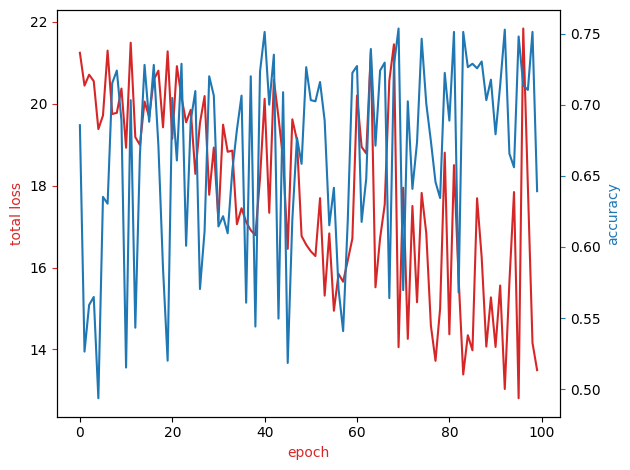

In [37]:
plot(loss, acc)

In [38]:
evaluate(test_dataloader, model)

100%|██████████| 782/782 [00:09<00:00, 84.07it/s]


0.6358

Let's load a model that has been pretrained using the same method but on the full data set and with 100 epochs.

The following code plots the cost and validation data accuracy for each epoch of the pretrained model up to and including the epoch that yielded the highest accuracy. As you can see, the pretrained model achieved an accuracy of over 85% on the validation set.


In [ ]:
# acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/sybqacL5p1qeEO8d4xRZNg/model-IMDB%20dataset%20small2-acc')
# loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/eOt6woGoaOB565T0RLH5WA/model-IMDB%20dataset%20small2-loss')
# acc_epoch = pickle.load(acc_urlopened)
# cum_loss_list = pickle.load(loss_urlopened)
# plot(cum_loss_list,acc_epoch)

The following code loads your pretrained model and evaluates its performance on the test set. **For efficiency, let's not run the evaluation because it can take approximately 4 minutes to run. Instead, report the result underneath the cell. If you would like to confirm the result for yourself, you are free to uncomment the last line in the following code block.**


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/q66IH6a7lglkZ4haM6hB1w/model-IMDB%20dataset%20small2.pth')
model_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_)

As you can see, the pretrained model achieved an accuracy of approximately 83% on the test data.


### Fine-tune a model pretrained on the AG News data set

Rather than training a model on the IMDB data set as you did earlier, you can fine-tune a model that has been pretrained on the AG News data set, which is a collection of news articles. The goal of the AG News data set is to categorize news articles into one of four categories: Sports, Business, Sci/tech, or World. You’ll start training a model from scratch on the AG News data set. To save time, you can do this in just one cell. Also, for efficiency, ** comment out the training bit**. If you want to train the model for 2 epochs on a smaller data set to demonstrate what the training process would look like, uncomment the part that says `### Uncomment to Train ###` before running the cell. Training for 2 epochs on the reduced data set can take approximately 3 minutes.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Loss: 268.4121661186218


  1%|          | 1/100 [00:02<04:29,  2.72s/it]

0.27666666666666667
Epoch 2/100 - Loss: 261.4755519628525


  2%|▏         | 2/100 [00:04<04:00,  2.46s/it]

Epoch 3/100 - Loss: 258.7538857460022


  3%|▎         | 3/100 [00:07<03:57,  2.45s/it]

0.31916666666666665
Epoch 4/100 - Loss: 254.43988072872162


  4%|▍         | 4/100 [00:09<03:50,  2.40s/it]

0.37766666666666665
Epoch 5/100 - Loss: 250.5077497959137


  5%|▌         | 5/100 [00:12<03:46,  2.39s/it]

0.4161666666666667
Epoch 6/100 - Loss: 246.39360439777374


  6%|▌         | 6/100 [00:14<03:45,  2.40s/it]

Epoch 7/100 - Loss: 241.69116604328156


  7%|▋         | 7/100 [00:16<03:40,  2.37s/it]

0.422
Epoch 8/100 - Loss: 236.3860124349594


  8%|▊         | 8/100 [00:19<03:34,  2.33s/it]

0.435
Epoch 9/100 - Loss: 231.51049733161926


  9%|▉         | 9/100 [00:21<03:33,  2.34s/it]

0.48533333333333334
Epoch 10/100 - Loss: 228.3710611462593


 10%|█         | 10/100 [00:23<03:31,  2.35s/it]

Epoch 11/100 - Loss: 222.10733437538147


 11%|█         | 11/100 [00:26<03:32,  2.39s/it]

Epoch 12/100 - Loss: 218.22603797912598


 12%|█▏        | 12/100 [00:28<03:35,  2.45s/it]

Epoch 13/100 - Loss: 214.82829171419144


 13%|█▎        | 13/100 [00:31<03:33,  2.45s/it]

Epoch 14/100 - Loss: 210.88185608386993


 14%|█▍        | 14/100 [00:34<03:35,  2.51s/it]

0.486
Epoch 15/100 - Loss: 206.98531979322433


 15%|█▌        | 15/100 [00:36<03:29,  2.47s/it]

Epoch 16/100 - Loss: 200.72103375196457


 16%|█▌        | 16/100 [00:38<03:22,  2.41s/it]

0.5385
Epoch 17/100 - Loss: 195.83629804849625


 17%|█▋        | 17/100 [00:40<03:16,  2.37s/it]

0.5813333333333334
Epoch 18/100 - Loss: 191.0532233119011


 18%|█▊        | 18/100 [00:43<03:12,  2.35s/it]

Epoch 19/100 - Loss: 187.35628497600555


 19%|█▉        | 19/100 [00:45<03:09,  2.34s/it]

0.6046666666666667
Epoch 20/100 - Loss: 178.80761152505875


 20%|██        | 20/100 [00:47<03:06,  2.33s/it]

0.6335
Epoch 21/100 - Loss: 172.46803146600723


 21%|██        | 21/100 [00:50<03:04,  2.33s/it]

0.6346666666666667
Epoch 22/100 - Loss: 168.19087302684784


 22%|██▏       | 22/100 [00:52<03:01,  2.33s/it]

0.6398333333333334
Epoch 23/100 - Loss: 162.6527300775051


 23%|██▎       | 23/100 [00:55<03:06,  2.42s/it]

0.653
Epoch 24/100 - Loss: 157.5119833946228


 24%|██▍       | 24/100 [00:57<03:07,  2.47s/it]

Epoch 25/100 - Loss: 152.80075266957283


 25%|██▌       | 25/100 [01:00<03:09,  2.52s/it]

0.681
Epoch 26/100 - Loss: 145.5638230741024


 26%|██▌       | 26/100 [01:03<03:10,  2.57s/it]

0.6955
Epoch 27/100 - Loss: 144.49736180901527


 27%|██▋       | 27/100 [01:05<03:09,  2.60s/it]

Epoch 28/100 - Loss: 140.8872392475605


 28%|██▊       | 28/100 [01:08<03:08,  2.62s/it]

Epoch 29/100 - Loss: 136.95401713252068


 29%|██▉       | 29/100 [01:11<03:07,  2.64s/it]

0.7205
Epoch 30/100 - Loss: 133.5382838845253


 30%|███       | 30/100 [01:13<03:05,  2.64s/it]

Epoch 31/100 - Loss: 132.58964067697525


 31%|███       | 31/100 [01:16<02:55,  2.54s/it]

0.7403333333333333
Epoch 32/100 - Loss: 126.61788029968739


 32%|███▏      | 32/100 [01:18<02:48,  2.47s/it]

Epoch 33/100 - Loss: 123.56099128723145


 33%|███▎      | 33/100 [01:20<02:43,  2.43s/it]

Epoch 34/100 - Loss: 122.4129036962986


 34%|███▍      | 34/100 [01:22<02:37,  2.39s/it]

0.7456666666666667
Epoch 35/100 - Loss: 119.45488980412483


 35%|███▌      | 35/100 [01:25<02:33,  2.36s/it]

Epoch 36/100 - Loss: 116.16268303990364


 36%|███▌      | 36/100 [01:27<02:30,  2.35s/it]

0.7508333333333334
Epoch 37/100 - Loss: 113.57772822678089


 37%|███▋      | 37/100 [01:30<02:32,  2.42s/it]

0.755
Epoch 38/100 - Loss: 112.55440902709961


 38%|███▊      | 38/100 [01:33<02:39,  2.57s/it]

Epoch 39/100 - Loss: 109.49434769153595


 39%|███▉      | 39/100 [01:35<02:40,  2.63s/it]

Epoch 40/100 - Loss: 108.76959836483002


 40%|████      | 40/100 [01:38<02:40,  2.67s/it]

0.7571666666666667
Epoch 41/100 - Loss: 105.39010220766068


 41%|████      | 41/100 [01:41<02:37,  2.67s/it]

0.761
Epoch 42/100 - Loss: 103.9932741522789


 42%|████▏     | 42/100 [01:44<02:35,  2.68s/it]

Epoch 43/100 - Loss: 104.11258316040039


 43%|████▎     | 43/100 [01:46<02:33,  2.70s/it]

Epoch 44/100 - Loss: 101.94489279389381


 44%|████▍     | 44/100 [01:49<02:25,  2.60s/it]

Epoch 45/100 - Loss: 98.6833858937025


 45%|████▌     | 45/100 [01:51<02:18,  2.52s/it]

0.775
Epoch 46/100 - Loss: 98.40096254646778


 46%|████▌     | 46/100 [01:53<02:12,  2.46s/it]

Epoch 47/100 - Loss: 96.0145512521267


 47%|████▋     | 47/100 [01:56<02:11,  2.48s/it]

Epoch 48/100 - Loss: 92.78375067561865


 48%|████▊     | 48/100 [01:59<02:12,  2.55s/it]

Epoch 49/100 - Loss: 94.04846173524857


 49%|████▉     | 49/100 [02:01<02:11,  2.58s/it]

Epoch 50/100 - Loss: 90.91903114318848


 50%|█████     | 50/100 [02:04<02:09,  2.59s/it]

Epoch 51/100 - Loss: 92.85619404911995


 51%|█████     | 51/100 [02:06<02:07,  2.61s/it]

0.7801666666666667
Epoch 52/100 - Loss: 88.48909075558186


 52%|█████▏    | 52/100 [02:09<02:06,  2.64s/it]

Epoch 53/100 - Loss: 87.71570485830307


 53%|█████▎    | 53/100 [02:12<02:05,  2.67s/it]

Epoch 54/100 - Loss: 85.219617202878


 54%|█████▍    | 54/100 [02:14<02:01,  2.64s/it]

0.7871666666666667
Epoch 55/100 - Loss: 84.79642316699028


 55%|█████▌    | 55/100 [02:17<02:00,  2.67s/it]

Epoch 56/100 - Loss: 82.53205206990242


 56%|█████▌    | 56/100 [02:20<01:57,  2.67s/it]

Epoch 57/100 - Loss: 82.08698379993439


 57%|█████▋    | 57/100 [02:23<01:55,  2.68s/it]

Epoch 58/100 - Loss: 80.14342454075813


 58%|█████▊    | 58/100 [02:25<01:52,  2.68s/it]

Epoch 59/100 - Loss: 82.43058724701405


 59%|█████▉    | 59/100 [02:28<01:49,  2.68s/it]

0.792
Epoch 60/100 - Loss: 78.74189769476652


 60%|██████    | 60/100 [02:31<01:47,  2.68s/it]

0.7936666666666666
Epoch 61/100 - Loss: 76.60001472383738


 61%|██████    | 61/100 [02:33<01:46,  2.74s/it]

Epoch 62/100 - Loss: 77.64617430791259


 62%|██████▏   | 62/100 [02:36<01:43,  2.73s/it]

Epoch 63/100 - Loss: 74.80672000348568


 63%|██████▎   | 63/100 [02:39<01:41,  2.74s/it]

0.7961666666666667
Epoch 64/100 - Loss: 74.69844161719084


 64%|██████▍   | 64/100 [02:42<01:38,  2.74s/it]

Epoch 65/100 - Loss: 73.5035179592669


 65%|██████▌   | 65/100 [02:44<01:34,  2.71s/it]

Epoch 66/100 - Loss: 73.75124603509903


 66%|██████▌   | 66/100 [02:47<01:32,  2.71s/it]

0.7978333333333333
Epoch 67/100 - Loss: 72.45620816200972


 67%|██████▋   | 67/100 [02:50<01:28,  2.69s/it]

Epoch 68/100 - Loss: 70.31449657678604


 68%|██████▊   | 68/100 [02:52<01:25,  2.67s/it]

Epoch 69/100 - Loss: 67.46484776586294


 69%|██████▉   | 69/100 [02:55<01:22,  2.67s/it]

0.8028333333333333
Epoch 70/100 - Loss: 69.30936137586832


 70%|███████   | 70/100 [02:58<01:19,  2.66s/it]

Epoch 71/100 - Loss: 67.1449421197176


 71%|███████   | 71/100 [03:00<01:15,  2.60s/it]

Epoch 72/100 - Loss: 67.21795839816332


 72%|███████▏  | 72/100 [03:03<01:13,  2.63s/it]

Epoch 73/100 - Loss: 66.70793202519417


 73%|███████▎  | 73/100 [03:05<01:11,  2.65s/it]

Epoch 74/100 - Loss: 64.3497014939785


 74%|███████▍  | 74/100 [03:08<01:09,  2.65s/it]

Epoch 75/100 - Loss: 65.58236431330442


 75%|███████▌  | 75/100 [03:11<01:06,  2.67s/it]

0.8088333333333333
Epoch 76/100 - Loss: 63.887076303362846


 76%|███████▌  | 76/100 [03:14<01:03,  2.67s/it]

Epoch 77/100 - Loss: 62.842747651040554


 77%|███████▋  | 77/100 [03:16<01:01,  2.67s/it]

Epoch 78/100 - Loss: 63.13746836036444


 78%|███████▊  | 78/100 [03:19<00:57,  2.63s/it]

Epoch 79/100 - Loss: 60.26606775820255


 79%|███████▉  | 79/100 [03:21<00:55,  2.65s/it]

Epoch 80/100 - Loss: 61.040796138346195


 80%|████████  | 80/100 [03:24<00:53,  2.66s/it]

Epoch 81/100 - Loss: 63.001896508038044


 81%|████████  | 81/100 [03:27<00:49,  2.60s/it]

Epoch 82/100 - Loss: 59.156406827270985


 82%|████████▏ | 82/100 [03:29<00:45,  2.51s/it]

Epoch 83/100 - Loss: 59.44703208655119


 83%|████████▎ | 83/100 [03:31<00:41,  2.45s/it]

Epoch 84/100 - Loss: 58.22485239803791


 84%|████████▍ | 84/100 [03:34<00:39,  2.46s/it]

Epoch 85/100 - Loss: 56.873144529759884


 85%|████████▌ | 85/100 [03:36<00:36,  2.41s/it]

0.8093333333333333
Epoch 86/100 - Loss: 57.537158131599426


 86%|████████▌ | 86/100 [03:38<00:33,  2.37s/it]

0.8106666666666666
Epoch 87/100 - Loss: 57.12242114543915


 87%|████████▋ | 87/100 [03:41<00:30,  2.34s/it]

Epoch 88/100 - Loss: 55.13605756685138


 88%|████████▊ | 88/100 [03:43<00:27,  2.33s/it]

Epoch 89/100 - Loss: 54.18859728053212


 89%|████████▉ | 89/100 [03:45<00:26,  2.39s/it]

Epoch 90/100 - Loss: 53.374730579555035


 90%|█████████ | 90/100 [03:48<00:23,  2.38s/it]

Epoch 91/100 - Loss: 55.03310824558139


 91%|█████████ | 91/100 [03:50<00:21,  2.37s/it]

Epoch 92/100 - Loss: 54.96420319378376


 92%|█████████▏| 92/100 [03:52<00:18,  2.35s/it]

Epoch 93/100 - Loss: 53.66385479271412


 93%|█████████▎| 93/100 [03:55<00:16,  2.34s/it]

Epoch 94/100 - Loss: 50.790043253451586


 94%|█████████▍| 94/100 [03:57<00:13,  2.32s/it]

Epoch 95/100 - Loss: 52.01364193484187


 95%|█████████▌| 95/100 [03:59<00:11,  2.31s/it]

Epoch 96/100 - Loss: 53.74738456681371


 96%|█████████▌| 96/100 [04:01<00:09,  2.30s/it]

Epoch 97/100 - Loss: 50.75678122416139


 97%|█████████▋| 97/100 [04:04<00:06,  2.31s/it]

Epoch 98/100 - Loss: 50.36766776815057


 98%|█████████▊| 98/100 [04:06<00:04,  2.30s/it]

Epoch 99/100 - Loss: 48.9400605019182


 99%|█████████▉| 99/100 [04:09<00:02,  2.34s/it]

Epoch 100/100 - Loss: 50.04333075135946


100%|██████████| 100/100 [04:11<00:00,  2.52s/it]

Training time: 251.54582357406616


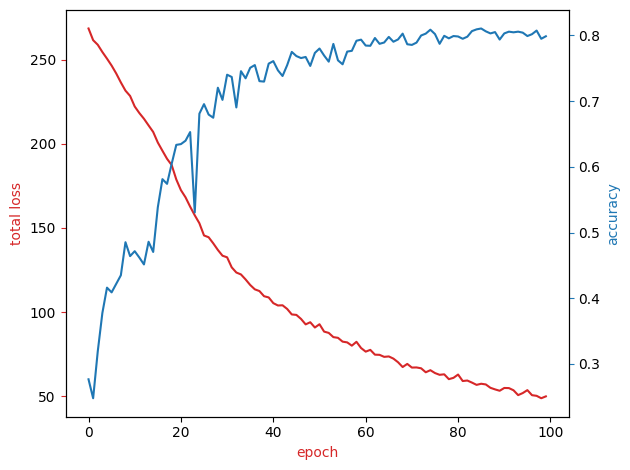

In [40]:
train_iter_ag_news = AG_NEWS(split="train")

num_class_ag_news = len(set([label for (label, text) in train_iter_ag_news ]))
num_class_ag_news

# Split the dataset into training and testing iterators.
train_iter_ag_news, test_iter_ag_news = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset_ag_news = to_map_style_dataset(train_iter_ag_news)
test_dataset_ag_news = to_map_style_dataset(test_iter_ag_news)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train_ag_news = int(len(train_dataset_ag_news) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_ag_news_, split_valid_ag_news_ = random_split(train_dataset_ag_news, [num_train_ag_news, len(train_dataset_ag_news) - num_train_ag_news])

# Make the training set smaller to allow it to run fast as an example.
# IF YOU WANT TO TRAIN ON THE AG_NEWS DATASET, COMMENT OUT THE 2 LINEs BELOW.
# HOWEVER, NOTE THAT TRAINING WILL TAKE A LONG TIME
num_train_ag_news = int(len(train_dataset_ag_news) * 0.05)
split_train_ag_news_, _ = random_split(split_train_ag_news_, [num_train_ag_news, len(split_train_ag_news_) - num_train_ag_news])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

def label_pipeline(x):
   return int(x) - 1

from torch.nn.utils.rnn import pad_sequence

def collate_batch_ag_news(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 32

train_dataloader_ag_news = DataLoader(
    split_train_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
valid_dataloader_ag_news = DataLoader(
    split_valid_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
test_dataloader_ag_news = DataLoader(
    test_dataset_ag_news, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)


model_ag_news = Net(num_class=4,vocab_size=vocab_size).to(device)
model_ag_news.to(device)

''''''
### Uncomment to Train ###
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_AG News small1.pth"
loss, acc = train_model(model=model_ag_news, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader_ag_news, valid_dataloader=valid_dataloader_ag_news,  epochs=100, save_dir=save_dir, file_name=file_name)
plot(loss, acc)

Let's load a model that has been pretrained using the same method but on the full AG News data set for 100 epochs.

The following code plots the cost and validation data accuracy for each epoch of the pretrained model up to and including the epoch that yielded the highest accuracy. As you can see, the pretrained model achieved a very high accuracy of over 90% on the AG News validation set.


In [41]:
evaluate(test_dataloader_ag_news, model)

100%|██████████| 238/238 [00:01<00:00, 224.87it/s]


0.24078947368421053

In [ ]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bQk8mJu3Uct3I4JEsEtRnw/model-AG%20News%20small1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KNQkqJWWwY_XfbFBRFhZNA/model-AG%20News%20small1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following code loads the pretrained model and evaluates its performance on the AG News test set. **For efficiency, let's not run the evaluation because it can take a few minutes. Instead, claim that the pretrained model works well on the AG News dataset. If you would like to confirm the result for yourself, feel free to uncomment the last line in the following code block.**


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_ag_news_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_ag_news_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader_ag_news, model_ag_news_)

As you can see, the pretrained model worked extremely well on the AG News data set. However, can this model be fine-tuned to perform well on the IMDB data set as well? Let's find out! You can begin by loading the pretrained AG News model.


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine1 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine1.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))


The IMDB dataset is a binary classification task with only two classes (positive and negative reviews). Therefore, the output layer of the AG NEWS model should be adjusted to have just two output neurons to reflect the binary nature of the IMDB dataset. This adjustment is essential for the model to accurately learn and predict the sentiment of movie reviews in the IMDB dataset.


In [ ]:
model_fine1.classifier
in_features = model_fine1.classifier.in_features
print("Original final layer:", model_fine1.classifier)
print("Input dimention  final layer:", in_features)

You can change the final layer into a two-class problem.


In [ ]:
model_fine1.classifier = nn.Linear(in_features, 2)
model_fine1.to(device)

The following code shows the layers that are frozen (`requires_grad == False`) and unfrozen (`requires_grad == True`) in the model. The unfrozen layers will have their weights updated during fine-tuning.


In [ ]:
for name, param in model_fine1.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

The following code block simulates fine-tuning on the shortened training set for just 2 epochs. **For the sake of time efficiency, this code block has been commented out**. If you want to see what training looks like, uncomment the following code block, but remember that this code could take approximately 2 minutes to run.


In [ ]:
'''
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine1.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine1.pth"
train_model(model=model_fine1, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )
'''

The following code shows the progress of full fine-tuning of the entire IMDB training set for 100 epochs.


In [ ]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/3LEJw8BRgJJFGqlLxaETxA/model-fine1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/-CT1h97vjv0TolY82Nw29g/model-fine1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following line loads a prefine-tuned model that was trained for 100 epochs on the full IMDB training set and evaluates its performance on the IMDB test set. **For the sake of efficiency, let's not run the evaluation because it can take a few minutes to run. Instead, report the result underneath the cell. If you would like to confirm the result for yourself, feel free to uncomment the last line in the code block.**


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/e0WOHKh5dnrbC2lGhpsMMw/model-fine1.pth')
model_fine1_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine1_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_fine1_)

This model demonstrated notable improvement, exhibiting a remarkable achievement with an accuracy of 86% on the test data. This is higher than the 83% achieved by the model trained from scratch on the IMDB dataset. Although the training process was time-intensive (The fine-tuning was as time-intensive as training the model from scratch), the enhanced performance underscores the fine-tuned model's effectiveness and superiority over the model trained from scratch. Much of the computational effort was devoted to updating the transformer layers. To expedite the training process, one viable strategy is to focus on training the final layer only, which can significantly reduce the computational load but might compromise the model's accuracy.


### Fine-tune the final layer only

Fine-tuning the final output layer of a neural network is similar to fine-tuning the whole model. You can begin by loading the pretrained model that you would like to fine-tune. In this case, it is the same model pretrained on the AG News data set.


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine2 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine2.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

Now, the key difference. You iterate through all of the parameters in the `model_fine2` model and set the `requires_grad` attribute of each parameter to `False`. This effectively freezes all of the layers in the model, meaning that their weights are to be updated during training.


In [ ]:
# Freeze all layers in the model
for param in model_fine2.parameters():
    param.requires_grad = False

Replace the final layer to reflect the fact that you are solving a two-class problem. Note that the new layer will be unfrozen.


In [ ]:
dim=model_fine2.classifier.in_features

In [ ]:
model_fine2.classifier = nn.Linear(dim, 2)

In [ ]:
model_fine2.to(device)


The following block simulates fine-tuning on the shortened training set for just 2 epochs. **For the sake of time efficiency, this code block has been commented out**. The following code should take a shorter amount of time to train than the full fine-tuning conducted previously because only the final layer is unfrozen.


In [ ]:
'''
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fine2.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_fine2.pth"
train_model(model=model_fine2, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )
'''

Once again, you will not use the model that you just fine-tuned, but instead inspect the final layer fine-tuning process of a model fine-tuned on the full IMDB training set for 100 epochs.


In [ ]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UdR3ApQnxSeV2mrA0CbiLg/model-fine2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rWGDIF-uL2dEngWcIo9teQ/model-fine2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following line loads the pretrained model and evaluates its performance on the test set. **For efficiency, let's not run the evaluation because it can take a few minutes to run. Instead, report the result underneath the cell. If you would like to confirm the result for yourself, feel free to uncomment the last line in the following code block.**


In [ ]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/B-1H6lpDg-A0zRwpB6Ek2g/model-fine2.pth')
model_fine2_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine2_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_fine2_)

The previous code indicates that although fine-tuning the final layer takes a significantly smaller amount of time than fine-tuning the whole model, the performance of the model with just the last layer unfrozen is significantly worse (64% accuracy) than the fine-tuned model with all layers unfrozen (86% accuracy).


---


# Adapters
FeatureAdapter is a neural network module that introduces a low-dimensional bottleneck in a transformer architecture to allow fine-tuning with fewer parameters. It compresses the original high-dimensional embeddings into a lower dimension, applies a non-linear transformation, and then expands it back to the original dimension. This process is followed by a residual
connection that adds the transformed output back to the original input to preserve information and
promote gradient flow.

## Benefits of using adapters in neural networks

- **Efficient fine-tuning**: Adapters allow for targeted updates to specific parts of the model, reducing the need to retrain large sections of the network.

- **Parameter efficiency**: By adding only a few parameters, adapters make it feasible to modify large models without substantial computational overhead.

- **Preservation of pretrained features**: Adapters enable the modification of a model while retaining the valuable features learned during extensive pretraining.

- **Modularity and flexibility**: They enhance the modularity of models, allowing easy adaptation to various tasks without altering core architecture.

- **Task-specific adaptation**: Adapters can be tailored to improve performance on particular tasks, optimizing the model’s effectiveness.

- **Transfer learning and domain adaptation**: They facilitate the adaptation of models to new domains, bridging gaps between different data distributions.

- **Continual learning**: Adapters support the model's ability to learn new information continuously without forgetting previous knowledge.

- **Reduced risk of overfitting**: With fewer trainable parameters, adapters help prevent overfitting, especially on smaller data sets.

The following code shows an adapter model.


In [42]:
class FeatureAdapter(nn.Module):
    """
    Attributes:
        size (int): The bottleneck dimension to which the embeddings are temporarily reduced.
        model_dim (int): The original dimension of the embeddings or features in the transformer model.
    """
    def __init__(self, bottleneck_size=50, model_dim=100):
        super().__init__()
        self.bottleneck_transform = nn.Sequential(
            nn.Linear(model_dim, bottleneck_size),  # Down-project to a smaller dimension
            nn.ReLU(),                             # Apply non-linearity
            nn.Linear(bottleneck_size, model_dim)  # Up-project back to the original dimension
        )

    def forward(self, x):
        """
        Forward pass of the FeatureAdapter. Applies the bottleneck transformation to the input
        tensor and adds a skip connection.

        Args:
            x (Tensor): Input tensor with shape (batch_size, seq_length, model_dim).

        Returns:
            Tensor: Output tensor after applying the adapter transformation and skip connection,
                    maintaining the original input shape.
        """
        transformed_features = self.bottleneck_transform(x)  # Transform features through the bottleneck
        output_with_residual = transformed_features + x      # Add the residual connection
        return output_with_residual

The adapted class wraps this adapter functionality around any specified linear layer, enhancing its output with the non-linearity of a ReLU activation function. This setup is particularly useful for experimenting with subtle architectural modifications in deep learning models, facilitating fine-tuning and potentially improving model performance on complex tasks.


In [43]:
class Adapted(nn.Module):
    def __init__(self, linear,bottleneck_size=None):
        super(Adapted, self).__init__()
        self.linear = linear
        model_dim = linear.out_features
        if bottleneck_size is None:
          bottleneck_size = model_dim//2   # Define default bottleneck size as half the model_dim

        # Initialize FeatureAdapter with calculated bottleneck_size and model_dim
        self.adaptor = FeatureAdapter(bottleneck_size=bottleneck_size, model_dim=model_dim)

    def forward(self, x):
        # First, the input x is passed through the linear layer
        x=self.linear(x)
        # Then it's adapted using FeatureAdapter
        x= self.adaptor(x)
        return x

You load the pretrained transformer model that was trained on the AG News dataset.


In [44]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_adapters = Net(vocab_size=vocab_size, num_class=4).to(device)
model_adapters.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>


First, freeze the parameters of a model named model_adapters to prevent them from being updated during training. Then, retrieve the number of input features for the classifier, and replace the classifier with a new linear layer that outputs to two classes.


In [45]:
for param in model_adapters.parameters():
    param.requires_grad = False

dim= model_adapters.classifier.in_features
model_adapters.classifier = nn.Linear(dim, 2)

Let's explore how to apply the adapted object to a linear layer to obtain the first output. You can obtain the unadapted linear layer for the first output by:


In [46]:
my_example_layer=model_adapters.transformer_encoder.layers[0].linear1
print(my_example_layer)

Linear(in_features=100, out_features=128, bias=True)


In the following code, you copy the linear layer and add an adapter layer to it.


In [47]:
my_adapted_layer=Adapted(my_example_layer)
print(my_adapted_layer)

Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
    )
  )
)


You can print the adapted layer and show that the new layers have their requires_grad attribute set to True, indicating that these layers will be updated during training.


In [48]:
for parm in my_adapted_layer.parameters():
    print(parm.requires_grad)

False
False
True
True
True
True


You can set a layer in the model to the adapter layer, as shown in the following code in the commented-out line. However, because there are many layers, a more systematic approach would be to traverse the model and replace specific layers with the adapter layer. Note that you should set the bottleneck size to 24, ensuring that there are fewer parameters to train than during a full fine-tuning.


In [ ]:
# Adapt a specific layer
#model_adapters.transformer_encoder.layers[0].linear1=Adapted(my_example_layer)

In [49]:
# Find number of layers
N_layers=len(model_adapters.transformer_encoder.layers)

In [50]:
# Traverse model and adapt
for n in range(N_layers):
  encoder=model_adapters.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)
    model_adapters.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)

 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=128, bias=True)
    )
  )
)
 before linear2
Linear(in_features=128, out_features=100, bias=True)
 after linear2
Adapted(
  (linear): Linear(in_features=128, out_features=100, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=100, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=100, bias=True)
    )
  )
)
 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
     

The following code sends the model to the device.


In [51]:
# Send model to device
model_adapters.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Adapted(
          (linear): Linear(in_features=100, out_features=128, bias=True)
          (adaptor): FeatureAdapter(
            (bottleneck_transform): Sequential(
              (0): Linear(in_features=128, out_features=24, bias=True)
              (1): ReLU()
              (2): Linear(in_features=24, out_features=128, bias=True)
            )
          )
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Adapted(
          (linear): Linear(in_features=128, out_features=100, bias=True)
          (adaptor): FeatureAdapter(
            (bottleneck_transform): 

Finally, the following code simulates training of the adapted model by training on a shortend IMDB train set for 2 epochs.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Loss: 28.08285617828369


  1%|          | 1/100 [00:01<02:50,  1.72s/it]

0.4928
Epoch 2/100 - Loss: 27.964613258838654


  2%|▏         | 2/100 [00:03<02:31,  1.55s/it]

0.508
Epoch 3/100 - Loss: 27.700832784175873


  3%|▎         | 3/100 [00:04<02:24,  1.49s/it]

0.5104
Epoch 4/100 - Loss: 27.767603397369385


  4%|▍         | 4/100 [00:06<02:22,  1.48s/it]

0.5408
Epoch 5/100 - Loss: 28.243772864341736


  5%|▌         | 5/100 [00:07<02:18,  1.46s/it]

Epoch 6/100 - Loss: 27.404882669448853


  6%|▌         | 6/100 [00:08<02:15,  1.45s/it]

0.5776
Epoch 7/100 - Loss: 27.417138040065765


  7%|▋         | 7/100 [00:10<02:14,  1.45s/it]

Epoch 8/100 - Loss: 27.356129825115204


  8%|▊         | 8/100 [00:11<02:12,  1.44s/it]

Epoch 9/100 - Loss: 26.464331328868866


  9%|▉         | 9/100 [00:13<02:09,  1.42s/it]

Epoch 10/100 - Loss: 26.442054867744446


 10%|█         | 10/100 [00:14<02:08,  1.43s/it]

Epoch 11/100 - Loss: 27.13774299621582


 11%|█         | 11/100 [00:16<02:07,  1.43s/it]

0.5896
Epoch 12/100 - Loss: 26.850547969341278


 12%|█▏        | 12/100 [00:17<02:05,  1.42s/it]

0.632
Epoch 13/100 - Loss: 26.529365956783295


 13%|█▎        | 13/100 [00:18<02:03,  1.42s/it]

Epoch 14/100 - Loss: 26.15634173154831


 14%|█▍        | 14/100 [00:20<02:02,  1.43s/it]

Epoch 15/100 - Loss: 24.963167436420918


 15%|█▌        | 15/100 [00:21<02:00,  1.42s/it]

Epoch 16/100 - Loss: 25.033051371574402


 16%|█▌        | 16/100 [00:23<01:59,  1.42s/it]

0.6576
Epoch 17/100 - Loss: 28.01600694656372


 17%|█▋        | 17/100 [00:24<01:58,  1.43s/it]

Epoch 18/100 - Loss: 24.12138403020799


 18%|█▊        | 18/100 [00:25<01:56,  1.42s/it]

Epoch 19/100 - Loss: 24.91645258665085


 19%|█▉        | 19/100 [00:27<01:55,  1.42s/it]

Epoch 20/100 - Loss: 24.846407681703568


 20%|██        | 20/100 [00:28<01:53,  1.42s/it]

Epoch 21/100 - Loss: 24.767643451690674


 21%|██        | 21/100 [00:30<01:52,  1.42s/it]

Epoch 22/100 - Loss: 25.38233745098114


 22%|██▏       | 22/100 [00:31<01:50,  1.42s/it]

0.6728
Epoch 23/100 - Loss: 24.732982724905014


 23%|██▎       | 23/100 [00:33<01:49,  1.42s/it]

Epoch 24/100 - Loss: 26.63667866587639


 24%|██▍       | 24/100 [00:34<01:48,  1.42s/it]

Epoch 25/100 - Loss: 24.58099788427353


 25%|██▌       | 25/100 [00:35<01:46,  1.42s/it]

Epoch 26/100 - Loss: 23.985596273094416


 26%|██▌       | 26/100 [00:37<01:45,  1.42s/it]

Epoch 27/100 - Loss: 22.87175242602825


 27%|██▋       | 27/100 [00:38<01:43,  1.42s/it]

Epoch 28/100 - Loss: 23.588546991348267


 28%|██▊       | 28/100 [00:40<01:42,  1.42s/it]

Epoch 29/100 - Loss: 24.266223698854446


 29%|██▉       | 29/100 [00:41<01:41,  1.43s/it]

0.6888
Epoch 30/100 - Loss: 23.008156061172485


 30%|███       | 30/100 [00:43<01:40,  1.44s/it]

Epoch 31/100 - Loss: 22.519804269075394


 31%|███       | 31/100 [00:44<01:39,  1.44s/it]

Epoch 32/100 - Loss: 22.59978848695755


 32%|███▏      | 32/100 [00:45<01:37,  1.43s/it]

0.696
Epoch 33/100 - Loss: 22.61591738462448


 33%|███▎      | 33/100 [00:47<01:36,  1.44s/it]

0.7008
Epoch 34/100 - Loss: 23.089019745588303


 34%|███▍      | 34/100 [00:48<01:36,  1.47s/it]

Epoch 35/100 - Loss: 22.210926204919815


 35%|███▌      | 35/100 [00:50<01:35,  1.47s/it]

Epoch 36/100 - Loss: 21.40053677558899


 36%|███▌      | 36/100 [00:51<01:33,  1.46s/it]

Epoch 37/100 - Loss: 21.233577946200967


 37%|███▋      | 37/100 [00:53<01:31,  1.45s/it]

Epoch 38/100 - Loss: 23.92747727036476


 38%|███▊      | 38/100 [00:54<01:30,  1.46s/it]

Epoch 39/100 - Loss: 22.054274797439575


 39%|███▉      | 39/100 [00:56<01:28,  1.45s/it]

0.7272
Epoch 40/100 - Loss: 21.997023448348045


 40%|████      | 40/100 [00:57<01:26,  1.44s/it]

Epoch 41/100 - Loss: 21.79085323214531


 41%|████      | 41/100 [00:59<01:24,  1.44s/it]

Epoch 42/100 - Loss: 20.66082201898098


 42%|████▏     | 42/100 [01:00<01:23,  1.43s/it]

Epoch 43/100 - Loss: 20.718657076358795


 43%|████▎     | 43/100 [01:01<01:21,  1.43s/it]

Epoch 44/100 - Loss: 20.457999870181084


 44%|████▍     | 44/100 [01:03<01:20,  1.43s/it]

Epoch 45/100 - Loss: 21.304577380418777


 45%|████▌     | 45/100 [01:04<01:18,  1.43s/it]

Epoch 46/100 - Loss: 21.423104643821716


 46%|████▌     | 46/100 [01:06<01:16,  1.42s/it]

Epoch 47/100 - Loss: 21.060491412878036


 47%|████▋     | 47/100 [01:07<01:15,  1.43s/it]

0.732
Epoch 48/100 - Loss: 20.111003398895264


 48%|████▊     | 48/100 [01:08<01:13,  1.42s/it]

Epoch 49/100 - Loss: 21.39389368891716


 49%|████▉     | 49/100 [01:10<01:12,  1.41s/it]

0.7336
Epoch 50/100 - Loss: 21.365881890058517


 50%|█████     | 50/100 [01:11<01:10,  1.42s/it]

Epoch 51/100 - Loss: 20.545547038316727


 51%|█████     | 51/100 [01:13<01:09,  1.41s/it]

Epoch 52/100 - Loss: 19.65860429406166


 52%|█████▏    | 52/100 [01:14<01:07,  1.40s/it]

Epoch 53/100 - Loss: 19.838284641504288


 53%|█████▎    | 53/100 [01:16<01:06,  1.41s/it]

Epoch 54/100 - Loss: 20.585799276828766


 54%|█████▍    | 54/100 [01:17<01:04,  1.41s/it]

Epoch 55/100 - Loss: 19.592463463544846


 55%|█████▌    | 55/100 [01:18<01:03,  1.40s/it]

Epoch 56/100 - Loss: 20.075266867876053


 56%|█████▌    | 56/100 [01:20<01:02,  1.41s/it]

Epoch 57/100 - Loss: 19.240423761308193


 57%|█████▋    | 57/100 [01:21<01:00,  1.42s/it]

Epoch 58/100 - Loss: 18.973768949508667


 58%|█████▊    | 58/100 [01:23<00:59,  1.42s/it]

Epoch 59/100 - Loss: 18.337102137506008


 59%|█████▉    | 59/100 [01:24<00:58,  1.44s/it]

0.7408
Epoch 60/100 - Loss: 18.182448118925095


 60%|██████    | 60/100 [01:26<00:57,  1.44s/it]

Epoch 61/100 - Loss: 18.354521811008453


 61%|██████    | 61/100 [01:27<00:55,  1.43s/it]

Epoch 62/100 - Loss: 18.24362227320671


 62%|██████▏   | 62/100 [01:28<00:54,  1.43s/it]

Epoch 63/100 - Loss: 18.77499716077


 63%|██████▎   | 63/100 [01:30<00:53,  1.44s/it]

Epoch 64/100 - Loss: 19.03752040863037


 64%|██████▍   | 64/100 [01:31<00:51,  1.44s/it]

Epoch 65/100 - Loss: 18.22312679886818


 65%|██████▌   | 65/100 [01:33<00:50,  1.44s/it]

0.7464
Epoch 66/100 - Loss: 17.238827442983165


 66%|██████▌   | 66/100 [01:34<00:48,  1.44s/it]

Epoch 67/100 - Loss: 17.499721504747868


 67%|██████▋   | 67/100 [01:36<00:47,  1.44s/it]

Epoch 68/100 - Loss: 18.064542464446276


 68%|██████▊   | 68/100 [01:37<00:45,  1.43s/it]

Epoch 69/100 - Loss: 18.00943173468113


 69%|██████▉   | 69/100 [01:38<00:44,  1.43s/it]

0.7504
Epoch 70/100 - Loss: 17.219418592751026


 70%|███████   | 70/100 [01:40<00:42,  1.43s/it]

Epoch 71/100 - Loss: 17.10019151866436


 71%|███████   | 71/100 [01:41<00:41,  1.43s/it]

Epoch 72/100 - Loss: 18.55992692708969


 72%|███████▏  | 72/100 [01:43<00:40,  1.44s/it]

Epoch 73/100 - Loss: 16.905170721933246


 73%|███████▎  | 73/100 [01:44<00:38,  1.44s/it]

Epoch 74/100 - Loss: 16.973617707611993


 74%|███████▍  | 74/100 [01:46<00:37,  1.43s/it]

Epoch 75/100 - Loss: 17.582583860028535


 75%|███████▌  | 75/100 [01:47<00:35,  1.43s/it]

Epoch 76/100 - Loss: 16.42613895237446


 76%|███████▌  | 76/100 [01:48<00:34,  1.44s/it]

Epoch 77/100 - Loss: 16.85614562034607


 77%|███████▋  | 77/100 [01:50<00:32,  1.43s/it]

Epoch 78/100 - Loss: 15.655919394921511


 78%|███████▊  | 78/100 [01:51<00:31,  1.44s/it]

Epoch 79/100 - Loss: 17.429377898573875


 79%|███████▉  | 79/100 [01:53<00:30,  1.43s/it]

Epoch 80/100 - Loss: 18.161597073078156


 80%|████████  | 80/100 [01:54<00:29,  1.45s/it]

Epoch 81/100 - Loss: 16.625587061047554


 81%|████████  | 81/100 [01:56<00:27,  1.46s/it]

Epoch 82/100 - Loss: 15.792528397869319


 82%|████████▏ | 82/100 [01:57<00:26,  1.45s/it]

Epoch 83/100 - Loss: 17.85936999320984


 83%|████████▎ | 83/100 [01:59<00:24,  1.46s/it]

Epoch 84/100 - Loss: 17.204526588320732


 84%|████████▍ | 84/100 [02:00<00:23,  1.45s/it]

Epoch 85/100 - Loss: 15.34673073887825


 85%|████████▌ | 85/100 [02:02<00:21,  1.44s/it]

Epoch 86/100 - Loss: 16.456842198967934


 86%|████████▌ | 86/100 [02:03<00:20,  1.45s/it]

Epoch 87/100 - Loss: 16.59175071120262


 87%|████████▋ | 87/100 [02:04<00:18,  1.44s/it]

Epoch 88/100 - Loss: 16.284102053847164


 88%|████████▊ | 88/100 [02:06<00:17,  1.44s/it]

0.7592
Epoch 89/100 - Loss: 17.247346088290215


 89%|████████▉ | 89/100 [02:07<00:15,  1.44s/it]

Epoch 90/100 - Loss: 18.509816840291023


 90%|█████████ | 90/100 [02:09<00:14,  1.45s/it]

Epoch 91/100 - Loss: 17.07879075407982


 91%|█████████ | 91/100 [02:10<00:13,  1.44s/it]

Epoch 92/100 - Loss: 15.620786905288696


 92%|█████████▏| 92/100 [02:12<00:11,  1.45s/it]

Epoch 93/100 - Loss: 18.36890895664692


 93%|█████████▎| 93/100 [02:13<00:10,  1.45s/it]

Epoch 94/100 - Loss: 14.225678395945579


 94%|█████████▍| 94/100 [02:15<00:08,  1.45s/it]

Epoch 95/100 - Loss: 14.48098755814135


 95%|█████████▌| 95/100 [02:16<00:07,  1.45s/it]

Epoch 96/100 - Loss: 15.092498419806361


 96%|█████████▌| 96/100 [02:17<00:05,  1.44s/it]

Epoch 97/100 - Loss: 14.90960115287453


 97%|█████████▋| 97/100 [02:19<00:04,  1.45s/it]

Epoch 98/100 - Loss: 15.705554276704788


 98%|█████████▊| 98/100 [02:20<00:02,  1.44s/it]

Epoch 99/100 - Loss: 15.703132942318916


 99%|█████████▉| 99/100 [02:22<00:01,  1.44s/it]

Epoch 100/100 - Loss: 16.04460023343563


100%|██████████| 100/100 [02:23<00:00,  1.44s/it]

Training time: 143.66167402267456


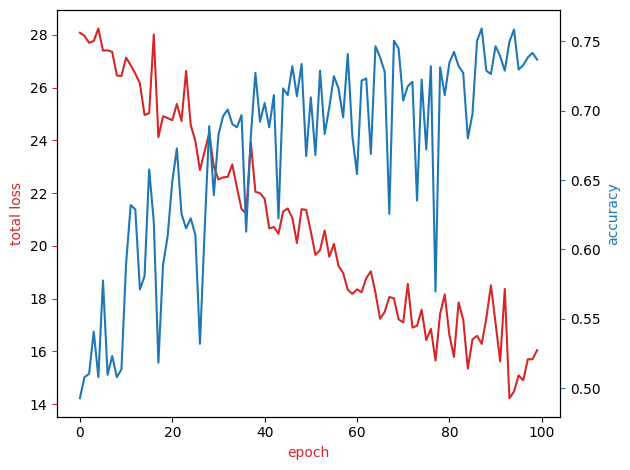

In [52]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_adapters.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_adapters.pth"
loss, acc = train_model(model=model_adapters, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=100,  save_dir=save_dir ,file_name=file_name )
plot(loss, acc)

In [53]:
evaluate(test_dataloader, model)

100%|██████████| 782/782 [00:09<00:00, 79.68it/s]


0.63372

Naturally, you will not use the model you just trained. Instead, you will track the training of an adapted model fine-tuned on the full IMDB dataset for 100 epochs.


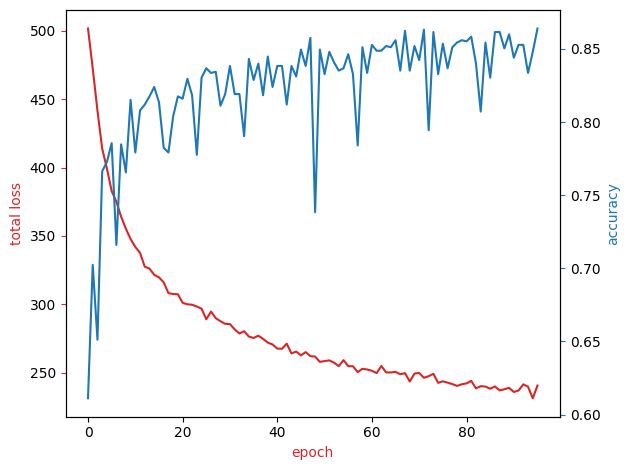

In [54]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/D49zrrMPWO_ktwQo7PSHIQ/model-adapters-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RXWlmyaco695RiaoU7QsnA/model-adapters-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

The following code loads the adapted model fine-tuned for 100 epochs on the full IMDB train set and evaluates its performance on the IMDB test set.


In [55]:
model_adapters_ = Net(vocab_size=vocab_size, num_class=2).to(device)
for n in range(N_layers):
  encoder=model_adapters_.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters_.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters_.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)
    model_adapters_.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)

model_adapters_.to(device)
for param in model_adapters_.parameters():
    param.requires_grad = False

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/PGhd5G_NVrWNH-_jdjwNlw/model-adapters.pth')
model_adapters_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_adapters_)

 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=128, bias=True)
    )
  )
)
 before linear2
Linear(in_features=128, out_features=100, bias=True)
 after linear2
Adapted(
  (linear): Linear(in_features=128, out_features=100, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=100, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=100, bias=True)
    )
  )
)
 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
     

100%|██████████| 782/782 [00:10<00:00, 73.19it/s]


0.85668

As you can see, the performance of the fine-tuned adapted model is nearly identical to the fully fine-tuned model, with both models achieving a roughly 86% accuracy. This is an especially surprising result because a significantly smaller number of weights were updated for the adapted model than the fully fine-tuned model. Note that only the adapter layers with a bottleneck size of 24 and the final classifier layer are unfrozen.


The above shows that adapters can be used for parameter efficient fine-tuning (PEFT) and that the performance of a model fine-tuned using adapters can be almost as good as a fully fine-tuned model with all of the layers unfrozen!


---


## Exercise: Adapt linear layers in a different network

The following code defines a neural network called `NeuralNetwork`.


In [76]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

exercise_model = NeuralNetwork()

exercise_model.to(device)
for param in exercise_model.parameters():
    param.requires_grad = False

print(exercise_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


`NeuralNetwork` is a neural network that uses the `Sequential` container from PyTorch. Adapt the first two linear layers in the `Sequential` container by using the bottleneck adapter with a bottleneck size of 30. Also, change the last linear layer to a layer that has 5 outputs.


In [77]:
### REPLACE THIS YOUR ANSWER ###
bottleneck_size=30
print(f'Before transformation: {exercise_model}')

exercise_model.linear_relu_stack[0]=Adapted(exercise_model.linear_relu_stack[0], bottleneck_size=bottleneck_size)
exercise_model.linear_relu_stack[2]=Adapted(exercise_model.linear_relu_stack[2], bottleneck_size=bottleneck_size)
print(f'After adding adapted layers: {exercise_model}')
in_feature_dim = exercise_model.linear_relu_stack[4].in_features
exercise_model.linear_relu_stack[4] = nn.Linear(in_feature_dim, 2)
print(f'After modified the last linear layer adapted layers: {exercise_model}')


### END OF YOUR ANSWER ###







Before transformation: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
After adding adapted layers: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Adapted(
      (linear): Linear(in_features=784, out_features=512, bias=True)
      (adaptor): FeatureAdapter(
        (bottleneck_transform): Sequential(
          (0): Linear(in_features=512, out_features=30, bias=True)
          (1): ReLU()
          (2): Linear(in_features=30, out_features=512, bias=True)
        )
      )
    )
    (1): ReLU()
    (2): Adapted(
      (linear): Linear(in_features=512, out_features=512, bias=True)
      (adaptor): FeatureAdapter(
        (bottleneck_transform): Sequential(
         

<details>
    <summary>Click here for the solution</summary>

```python
exercise_model.linear_relu_stack[0] = Adapted(exercise_model.linear_relu_stack[0], bottleneck_size=30)
exercise_model.linear_relu_stack[2] = Adapted(exercise_model.linear_relu_stack[2], bottleneck_size=30)
exercise_model.linear_relu_stack[4] = nn.Linear(512, 5)
print(exercise_model)
```

</details>


---


## Congratulations! You have completed the lab


## Authors


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo)

Joseph has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk) 

Wojciech "Victor" Fulmyk is a Data Scientist at IBM, and a PhD Candidate in economics at the University of Calgary.


[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS from Dalhousie University. He has previous experience working with Natural Language Processing and as a Data Scientist.


## References


[TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

[Parameter-Efficient Transfer Learning for NLP](https://arxiv.org/pdf/1902.00751.pdf)

[Simple, Scalable Adaptation for Neural Machine Translation](https://arxiv.org/pdf/1909.08478)


© Copyright IBM Corporation. All rights reserved.
